In [11]:
### imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as opt
from sklearn.model_selection import train_test_split
#from scipy import stats
#from scipy.integrate import trapz

In [12]:
### set hyper parameter
num_nodes = 16 # number of nodes in the hidden layer set to a low nomber for easier anlysis
num_epochs = 150 # number of epochs to be trained. This number is chosen very
#high to even give larger networks the chance to converge
noise = True # allows for adding noise to the labels of the training data

In [8]:
def f (x):
  x=x
  return x*x*x -5*x

(2500,)


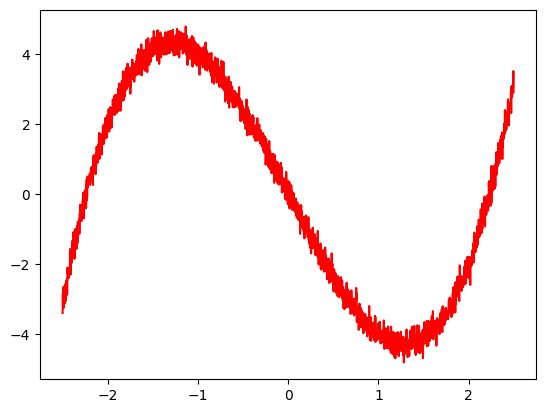

(2500,)


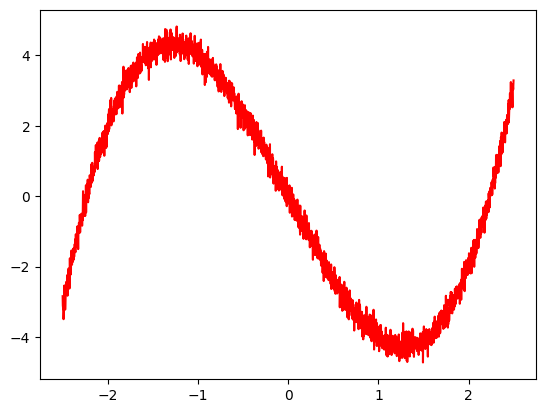

In [9]:
# plot function
x_v = np.arange(-2.5,2.5,0.002)
print(x_v.shape)
f_v = f(x_v)
# add noise
if noise:
  add_noise = np.random.normal(0,0.2,x_v.shape) # The noise level can be modified.
  f_v+=add_noise
plt.plot(x_v, f_v, color='red')

(2, 2500)


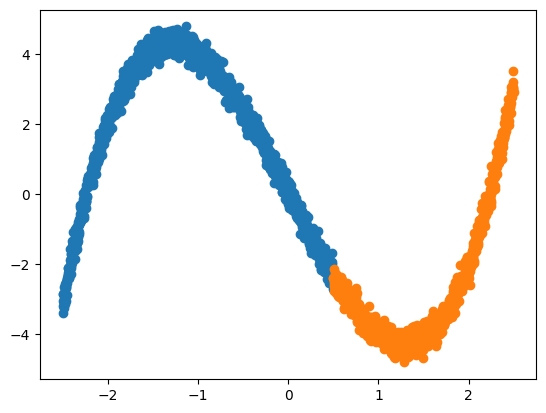

(2, 2500)


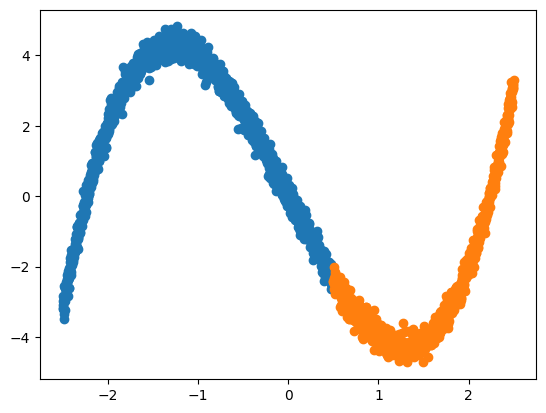

In [10]:

samples = np.hstack((x_v[:,np.newaxis], f_v[:,np.newaxis]))
print(np.transpose(samples).shape)
samples=samples[np.lexsort((samples[:,1],samples[:,0]))]
plt.scatter(samples[:1500,0],samples[:1500,1])
plt.scatter(samples[1500:,0],samples[1500:,1])
plt.show()